# Aggregating all of our data

With our parking, public transportation, and traffic data all cleaned and transformed, we can now aggregate it over DC census tracts, and use demographic data to come up with our final, and presentable data set.

In [139]:
import geopandas as gpd
import pandas as pd
import numpy as np

parking = gpd.read_file("../cleaned_data/cleaned_parking_zones.geojson")
public_transportation = gpd.read_file("../cleaned_data/public_transportation.geojson")
traffic = gpd.read_file("../cleaned_data/traffic_data.geojson")

#our new data sources
neighborhood_labels = gpd.read_file("../data/Neighborhood_Labels.geojson")
census_tracts = gpd.read_file("../data/Census_Tracts_in_2020.geojson")

dcBoundary = "../data/Washington_DC_Boundary_Stone_Area.geojson"
dcBoundary = gpd.read_file(dcBoundary)
dcBoundary = dcBoundary.to_crs(epsg=3857)


Transform, clean, and reduce data down to exactly what we need:

In [140]:
print(neighborhood_labels.columns)
print(census_tracts.columns)

Index(['OBJECTID', 'GIS_ID', 'NAME', 'WEB_URL', 'LABEL_NAME',
       'DATELASTMODIFIED', 'GLOBALID', 'CREATOR', 'CREATED', 'EDITOR',
       'EDITED', 'geometry'],
      dtype='str')
Index(['TRACT', 'GEOID', 'P0010001', 'P0010002', 'P0010003', 'P0010004',
       'P0010005', 'P0010006', 'P0010007', 'P0010008',
       ...
       'P0050005', 'P0050006', 'P0050007', 'P0050008', 'P0050009', 'P0050010',
       'OBJECTID', 'SHAPEAREA', 'SHAPELEN', 'geometry'],
      dtype='str', length=316)


In [141]:
neighborhood_labels = neighborhood_labels[["NAME", "geometry"]]
census_tracts = census_tracts[["TRACT", "P0010001", "geometry"]]

#rename columns for clarity
census_tracts = census_tracts.rename(columns={"P0010001": "POPULATION"})

## Basic (prelimenary) Visualization

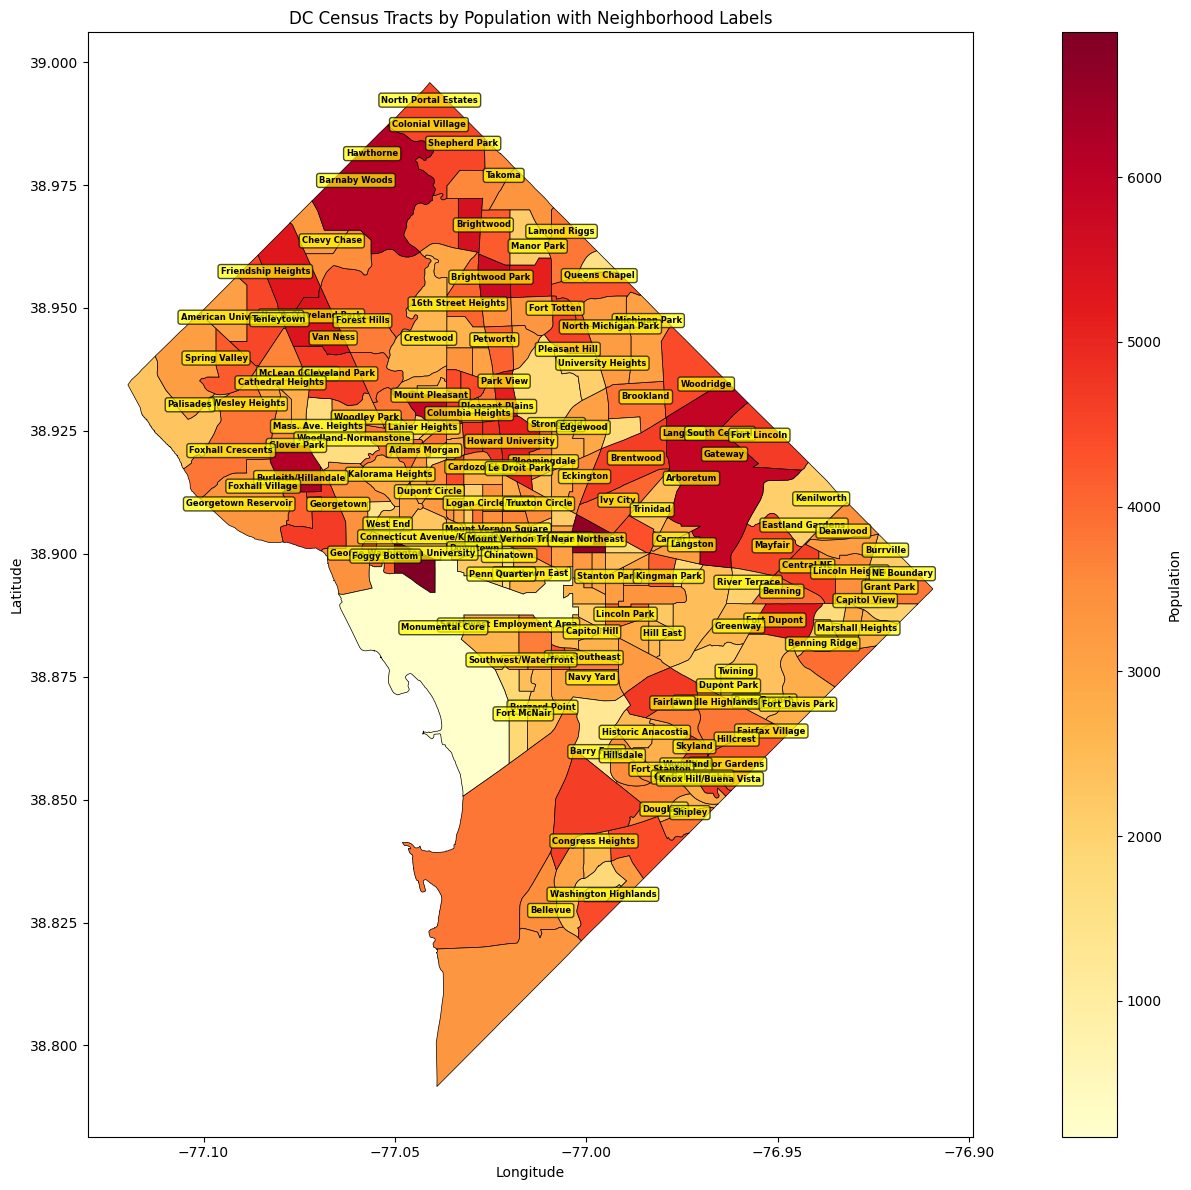

In [142]:
# visualize the lables and tracts, shading darker based on higher population, and using the labels to just label, use matplotlib
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(18, 12))

# Plot census tracts with population-based shading
census_tracts.plot(column='POPULATION', ax=ax, legend=True, 
				   cmap='YlOrRd', edgecolor='black', linewidth=0.5,
				   legend_kwds={'label': 'Population', 'orientation': 'vertical'})

# Overlay neighborhood labels as points with text annotations
for idx, row in neighborhood_labels.iterrows():
	ax.annotate(text=row['NAME'], xy=(row.geometry.x, row.geometry.y),
				ha='center', fontsize=6, weight='bold',
				bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('DC Census Tracts by Population with Neighborhood Labels')
plt.tight_layout()
plt.show()


## Aggregating Public Transportation Data by Census tract 

In [143]:
# Ensure both GeoDataFrames use the same CRS
census_tracts = census_tracts.to_crs(epsg=3857)
public_transportation = public_transportation.to_crs(epsg=3857)

# Spatial join: assign public transportation points to census tracts
joined = census_tracts.sjoin(public_transportation, how="left", predicate='contains')

# Count each type of public transportation per tract
counts = (joined.groupby(["TRACT", "TYPE"])
          .size()
          .unstack(fill_value=0)
          .reset_index())

# Merge counts back with population and geometry
census_tracts = census_tracts[["TRACT", "POPULATION", "geometry"]].merge(
    counts.rename(columns={
        "BUS STOP": "BUS_STOP_COUNT",
        "METRO STATION": "METRO_STATION_COUNT"
    }),
    on="TRACT",
    how="left"
)

# Aggregate by tract, keeping geometry
census_tracts = census_tracts.groupby(["TRACT", "geometry"]).agg({
    "POPULATION": "first",
    "BUS_STOP_COUNT": "sum",
    "METRO_STATION_COUNT": "sum"
}).reset_index()

# Convert back to GeoDataFrame if needed
census_tracts = gpd.GeoDataFrame(census_tracts, geometry="geometry", crs="EPSG:3857")

In [144]:
print(census_tracts.columns)

Index(['TRACT', 'geometry', 'POPULATION', 'BUS_STOP_COUNT',
       'METRO_STATION_COUNT'],
      dtype='str')


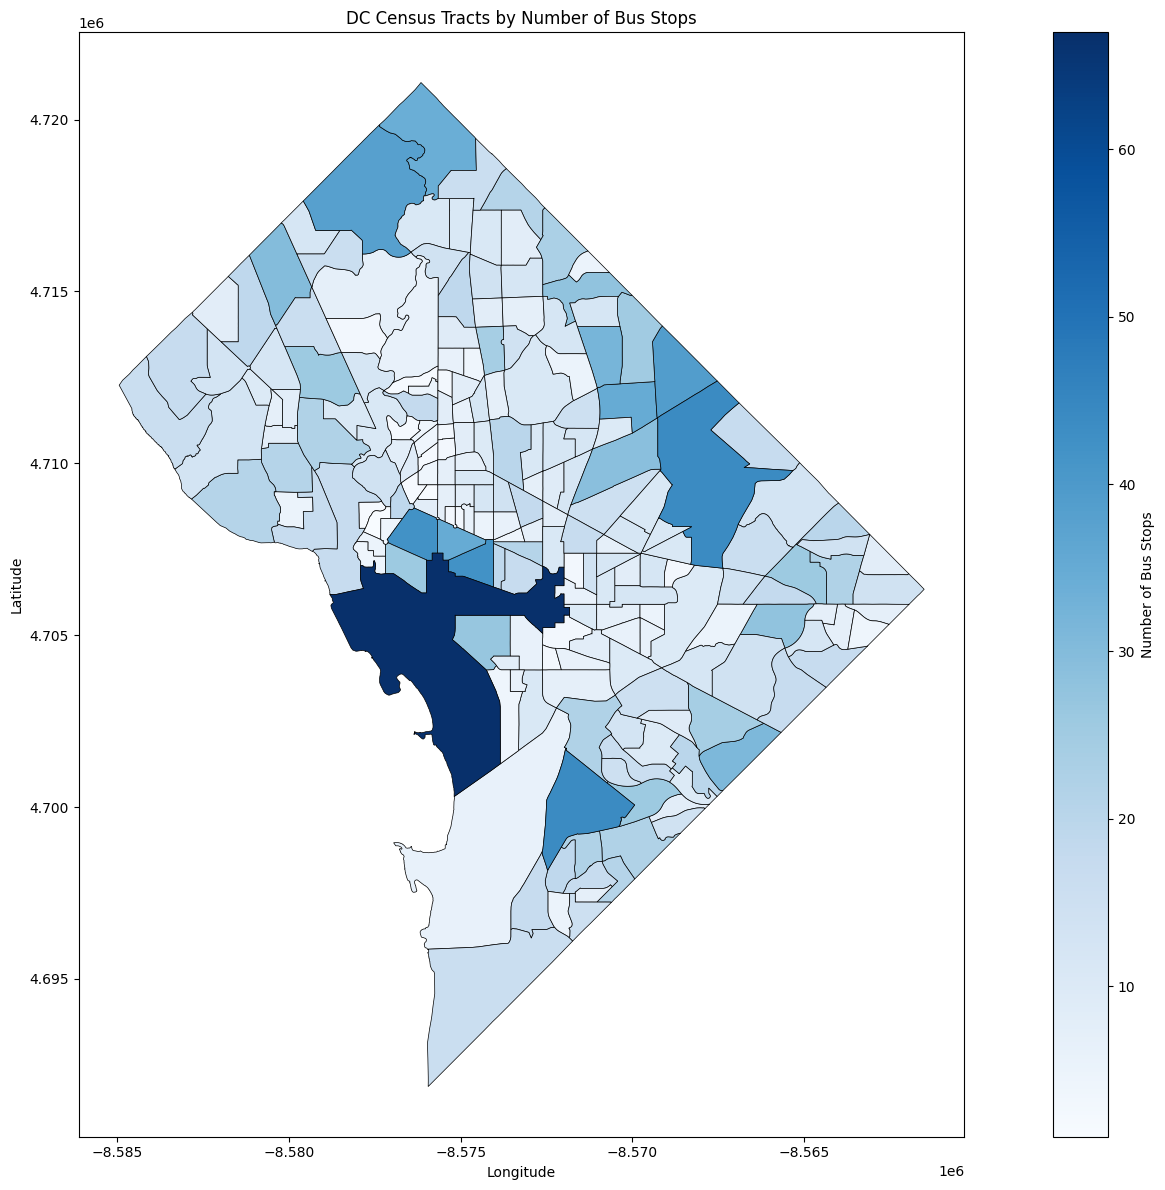

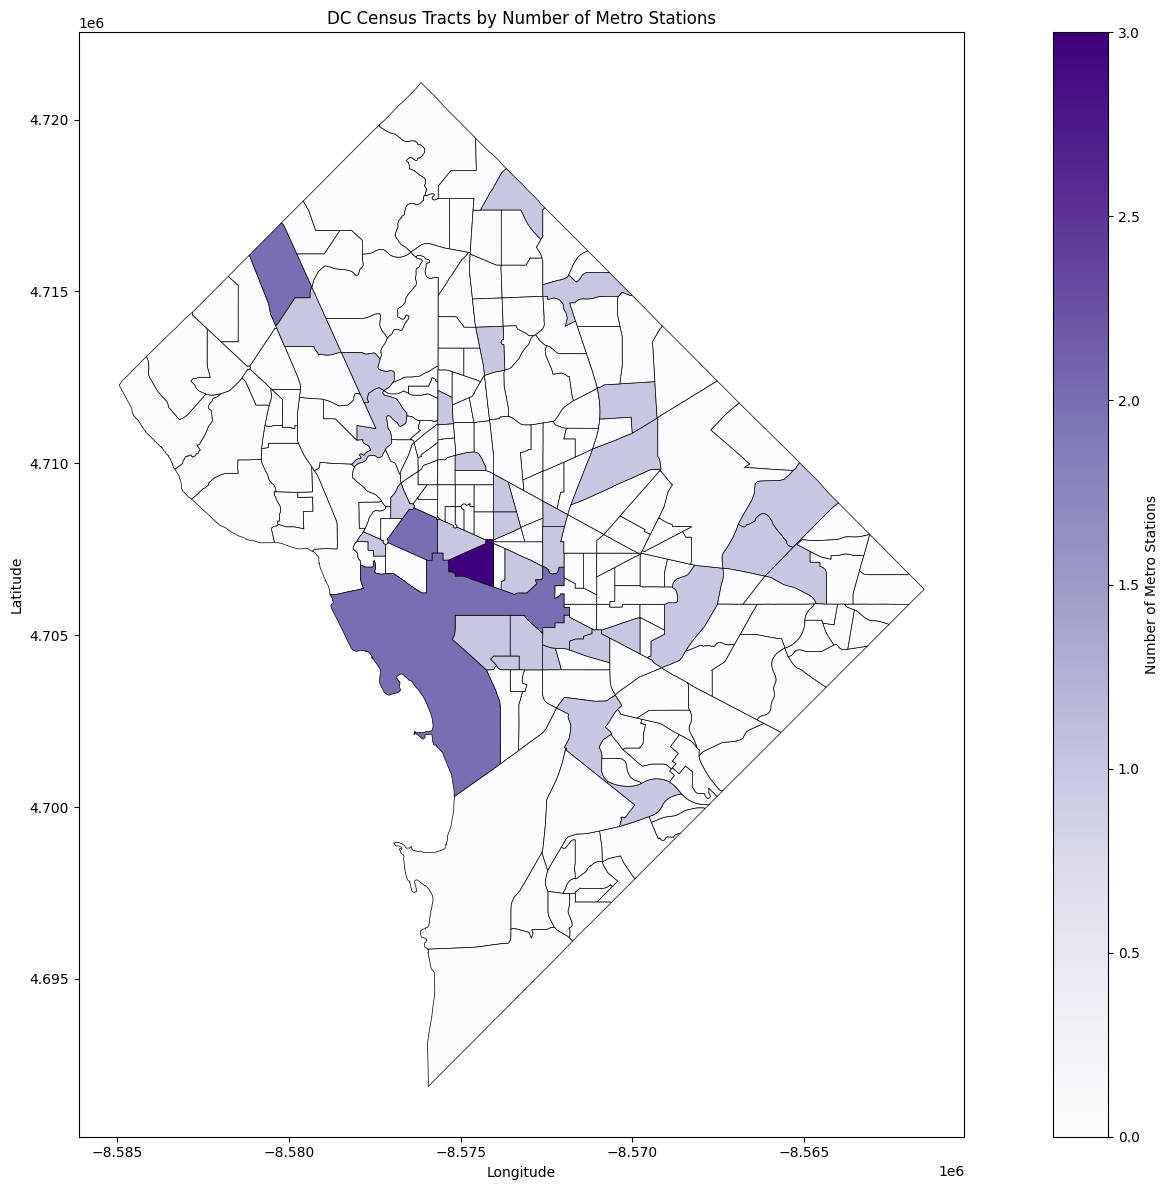

In [145]:
# Plot bus stops
fig, ax = plt.subplots(figsize=(18, 12))
census_tracts.plot(column='BUS_STOP_COUNT', ax=ax, legend=True, 
                   cmap='Blues', edgecolor='black', linewidth=0.5,
                   legend_kwds={'label': 'Number of Bus Stops', 'orientation': 'vertical'})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('DC Census Tracts by Number of Bus Stops')
plt.tight_layout()
plt.show()

# Plot metro stations
fig, ax = plt.subplots(figsize=(18, 12))
census_tracts.plot(column='METRO_STATION_COUNT', ax=ax, legend=True, 
                   cmap='Purples', edgecolor='black', linewidth=0.5,
                   legend_kwds={'label': 'Number of Metro Stations', 'orientation': 'vertical'})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('DC Census Tracts by Number of Metro Stations')
plt.tight_layout()
plt.show()

## Aggregating Traffic Data by Census tract 

In [ ]:
# aggregate traffic data by census tract, using the same spatial join method, and then sum the traffic counts for each tract, and then plot the traffic counts by tract, shading darker for higher traffic counts
# Ensure both GeoDataFrames use the same CRS
census_tracts_x = census_tracts.to_crs(epsg=3857)
traffic_x = traffic.to_crs(epsg=3857) 

# also adjust for roads being linestrings and not points, and thus using 'intersects' instead of 'contains', and adjust traffic count for percent of road in tract

# build a DC boundary from tracts to clip roads at the border
dc_boundary = census_tracts_x.unary_union

traffic_x["geometry_road"] = traffic_x.geometry
traffic_x["geometry_road_clipped"] = traffic_x["geometry_road"].intersection(dc_boundary)

joined_traffic = census_tracts_x.sjoin(
    traffic_x,
    how="left",
    predicate="intersects"
)

# length of each road segment clipped to DC and the portion that lies within each tract
joined_traffic["road_length"] = joined_traffic["geometry_road_clipped"].length
joined_traffic["intersection_length"] = joined_traffic.apply(
    lambda row: row.geometry.intersection(row["geometry_road_clipped"]).length if pd.notnull(row["AADT"]) else 0,
    axis=1
)

# split AADT by the share of each road that lies in each tract
joined_traffic["total_intersection_length"] = joined_traffic.groupby("geometry_road")["intersection_length"].transform("sum")
joined_traffic["adjusted_count"] = joined_traffic["AADT"] * (
    joined_traffic["intersection_length"] / joined_traffic["total_intersection_length"].replace(0, np.nan)
)
joined_traffic["adjusted_count"] = joined_traffic["adjusted_count"].fillna(0)

# go through joined traffic, and print out the sums of the intersection lengths for each road, and then print the total length of the road
# get max for road_length and then sum intersection lengths for each road, and then print the ratio of the sum of intersection lengths to the max road length for each road, to check if our adjustment is working correctly
road_lengths = joined_traffic.groupby("geometry_road")["road_length"].max()
intersection_sums = joined_traffic.groupby("geometry_road")["intersection_length"].sum()
ratios = intersection_sums / road_lengths.replace(0, np.nan)
# merge lengths and intersections together by road geometry
lengths_intersections = pd.DataFrame({
    "max_road_length": road_lengths,
    "sum_intersection_length": intersection_sums,
    "ratio": ratios
})
print(lengths_intersections[["ratio"]].describe())

# Sum adjusted traffic counts per tract
traffic_counts = joined_traffic.groupby("TRACT")["adjusted_count"].sum().reset_index()
traffic_counts = traffic_counts.rename(columns={"adjusted_count": "TOTAL_TRAFFIC_COUNT"})

# Merge traffic counts back with census tracts
census_tracts_x = census_tracts_x.merge(traffic_counts, on="TRACT", how="left")
census_tracts_x["TOTAL_TRAFFIC_COUNT"] = census_tracts_x["TOTAL_TRAFFIC_COUNT"].fillna(0)

# print(census_tracts_x)



             ratio
count  8530.000000
mean      1.088861
std       0.446684
min       0.000029
25%       1.000000
50%       1.000000
75%       1.000000
max       6.000000


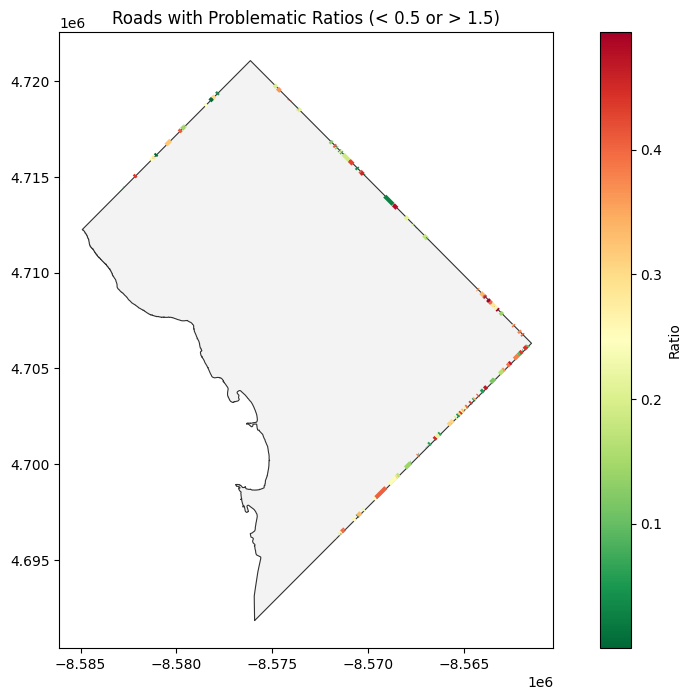

In [ ]:
# Filter for problematic roads (ratio < 0.5 or > 1.5)
problematic_mask = (lengths_intersections["ratio"] < 0.5) | (lengths_intersections["ratio"] > 1.5)
problematic_roads_gdf = lengths_intersections[problematic_mask]

# Convert index (geometry_road) into a geometry column to avoid plot errors
problematic_roads_gdf = problematic_roads_gdf.reset_index().rename(columns={"geometry_road": "geometry"})
problematic_roads_gdf = gpd.GeoDataFrame(
    problematic_roads_gdf,
    geometry="geometry",
    crs=dcBoundary.crs
)

# Plot problematic roads
fig, ax = plt.subplots(figsize=(12, 8))
dcBoundary.plot(ax=ax, color="#f0f0f0", edgecolor="black", linewidth=0.8, alpha=0.8)
problematic_roads_gdf.plot(
    ax=ax,
    column="ratio",
    cmap="RdYlGn_r",
    linewidth=3,
    legend=True,
    legend_kwds={"label": "Ratio", "orientation": "vertical"},
)
ax.set_title("Roads with Problematic Ratios (< 0.5 or > 1.5)")
plt.show()
